In [1]:
import pandas as pd

from jumpmodels.utils import filter_date_range        
from jumpmodels.jump import JumpModel
from jumpmodels.sparse_jump import SparseJumpModel

In [2]:
import sys
import os

dir = r"..\jump-models\examples\nasdaq"
sys.path.append(dir)
from feature import DataLoader

In [3]:
import os
print(os.getcwd())

d:\ETH & UZH\ETH\Machine Learning in Finance and Complex System\jump-models


In [4]:
data_raw = pd.read_csv("../jump-models/simulated_hmm_2000.csv")

In [5]:
return_117 = data_raw['returns_117']
return_117

0     -0.011021
1     -0.003012
2     -0.016031
3      0.006874
4     -0.009045
         ...   
995   -0.006636
996   -0.004425
997   -0.009126
998    0.004868
999    0.005775
Name: returns_117, Length: 1000, dtype: float64

In [6]:
dates = pd.date_range(start='2020-01-01',periods=len(return_117),freq='D')
return_117_series = pd.DataFrame({
    'date': dates,
    'close': return_117.values
})
return_117_series.head()

,date,close
0,2020-01-01,-0.011021
1,2020-01-02,-0.003012
2,2020-01-03,-0.016031
3,2020-01-04,0.006874
4,2020-01-05,-0.009045


In [7]:
return_117_series['ret'] = return_117_series['close'].pct_change()
return_117_series.head()

,date,close,ret
0,2020-01-01,-0.011021,NaN
1,2020-01-02,-0.003012,-0.726737
2,2020-01-03,-0.016031,4.322922
3,2020-01-04,0.006874,-1.428797
4,2020-01-05,-0.009045,-2.315816


In [8]:
return_117_series['date'] = pd.to_datetime(return_117_series['date'])
return_117_series.set_index('date', inplace=True)
return_117_series.head()

,close,ret
date,,
2020-01-01,-0.011021,NaN
2020-01-02,-0.003012,-0.726737
2020-01-03,-0.016031,4.322922
2020-01-04,0.006874,-1.428797
2020-01-05,-0.009045,-2.315816


In [9]:
return_117_series.to_pickle(r".\examples\nasdaq\data\HMM_117.pkl")

In [10]:
data = DataLoader(ticker="HMM_117", ver="v0").load()

print("Daily returns stored in `data.ret_ser`:", "-"*50, sep="\n")
print(data.ret_ser, "-"*50, sep="\n")
print("Features stored in `data.X`:", "-"*50, sep="\n")
print(data.X)

Daily returns stored in `data.ret_ser`:
--------------------------------------------------
date
2020-01-02   -0.726737
2020-01-03    4.322922
2020-01-04   -1.428797
2020-01-05   -2.315816
2020-01-06   -0.525239
                ...   
2022-09-22   -0.525042
2022-09-23   -0.333233
2022-09-24    1.062442
2022-09-25   -1.533461
2022-09-26    0.186247
Name: HMM_117, Length: 999, dtype: float64
--------------------------------------------------
Features stored in `data.X`:
--------------------------------------------------
               ret_5  DD-log_5  sortino_5    ret_20  DD-log_20  sortino_20     ret_60  DD-log_60  sortino_60
date                                                                                                        
2020-01-02 -0.726737 -0.319191  -1.000000 -0.726737  -0.319191   -1.000000  -0.726737  -0.319191   -1.000000
2020-01-03  1.972821 -0.701622   3.979221  1.841840  -0.674504    3.615640   1.812677  -0.668661    3.537659
2020-01-04  0.678647 -0.036838   0.704113

In [11]:
train_start, test_start = "2020-1-1", "2022-4-1"
# filter dates
X_train = filter_date_range(data.X, start_date=train_start, end_date=test_start)
X_test = filter_date_range(data.X, start_date=test_start)
# print time split
train_start, train_end = X_train.index[[0, -1]]
test_start, test_end = X_test.index[[0, -1]]
print("Training starts at:", train_start, "and ends at:", train_end)
print("Testing starts at:", test_start, "and ends at:", test_end)

Training starts at: 2020-01-02 00:00:00 and ends at: 2022-04-01 00:00:00
Testing starts at: 2022-04-01 00:00:00 and ends at: 2022-09-26 00:00:00


In [12]:
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
clipper = DataClipperStd(mul=3.)
scalar = StandardScalerPD()
# fit on training data
X_train_processed = scalar.fit_transform(clipper.fit_transform(X_train))
# transform the test data
X_test_processed = scalar.transform(clipper.transform(X_test))

In [16]:
# set the jump penalty
jump_penalty=0
# initlalize the JM instance
jm = JumpModel(n_components=2, jump_penalty=jump_penalty, cont=False, )

In [17]:
# call .fit()
jm.fit(X_train_processed, data.ret_ser, sort_by="cumret")

JumpModel(jump_penalty=0)

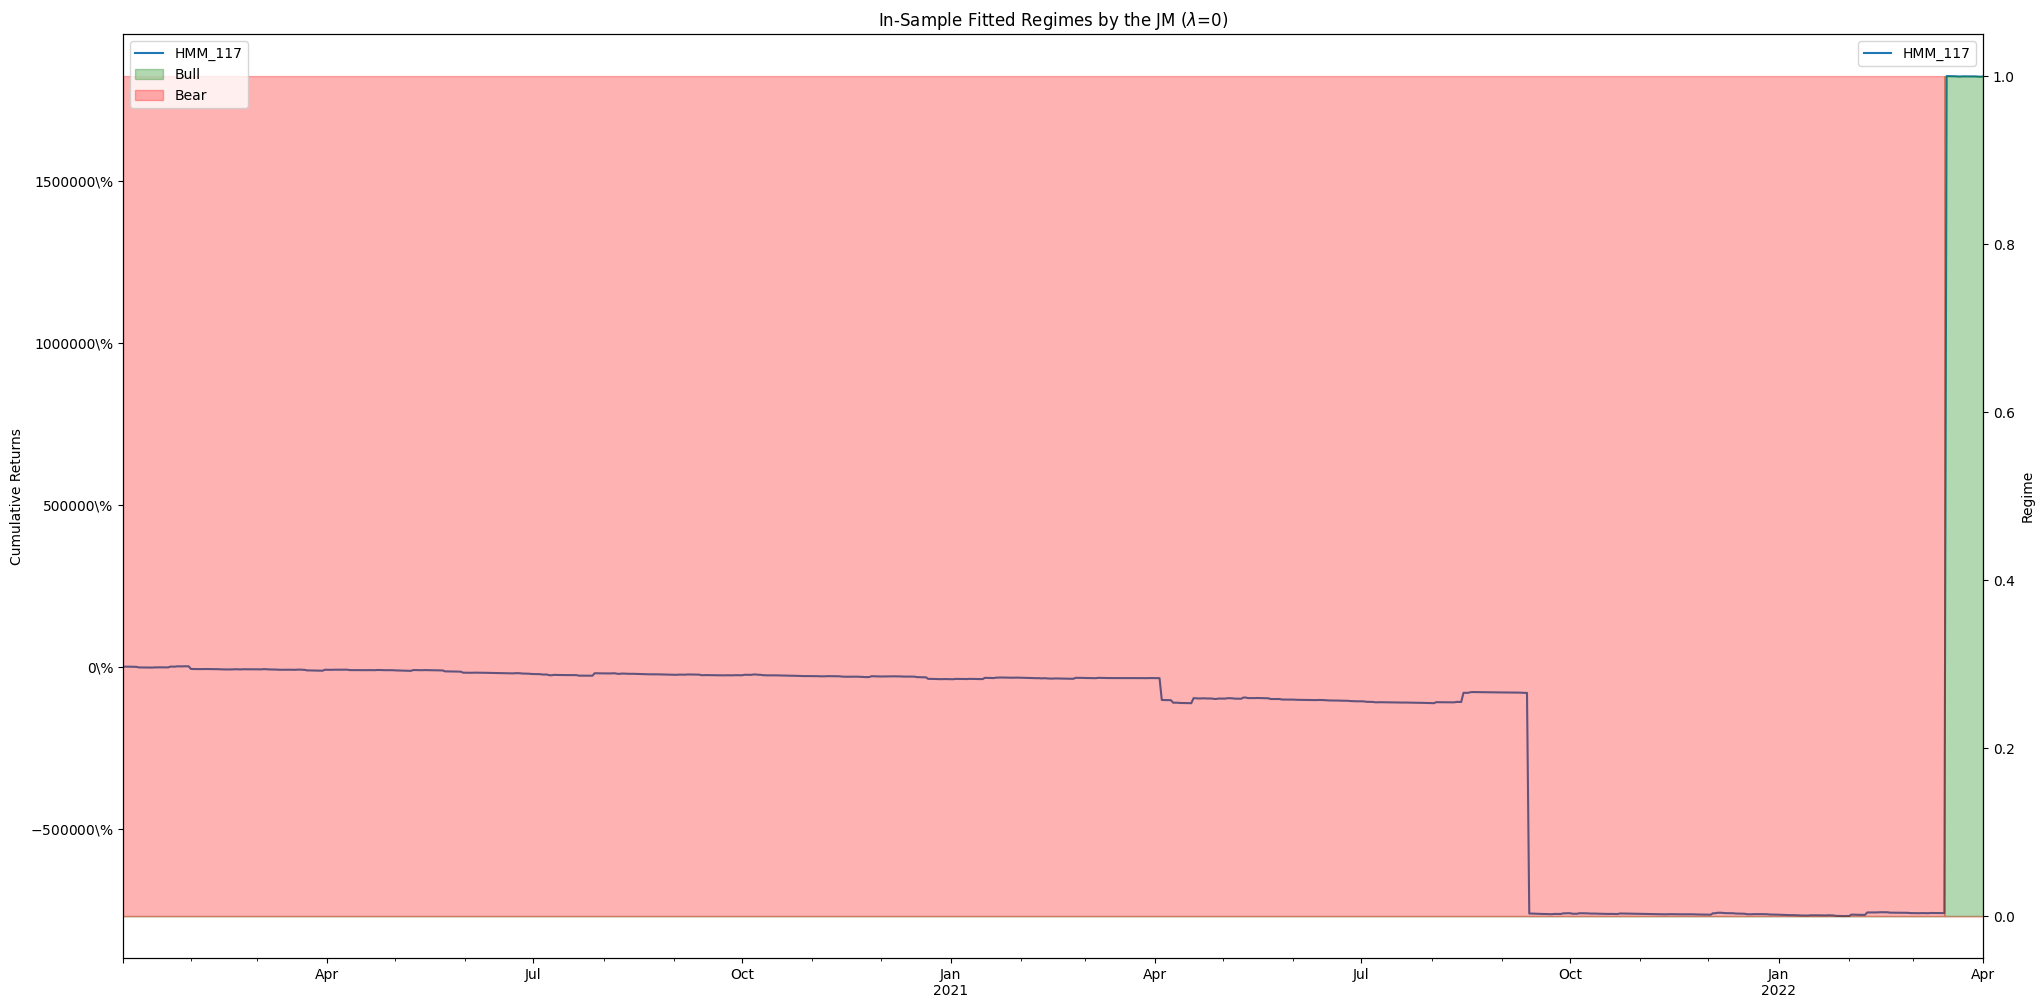

In [18]:
from utils_dir import get_curr_dir
from jumpmodels.plot import plot_regimes_and_cumret, savefig_plt

ax, ax2 = plot_regimes_and_cumret(jm.labels_, data.ret_ser, n_c=2, start_date=train_start, end_date=train_end, )
ax.set(title=f"In-Sample Fitted Regimes by the JM ($\\lambda$={jump_penalty})")
savefig_plt(f"{get_curr_dir()}/plots/JM_lambd-{jump_penalty}_train.pdf")

In [19]:
# refit
jump_penalty=0
jm.set_params(jump_penalty=jump_penalty).fit(X_train_processed, data.ret_ser, sort_by="cumret")
# make online inference 
labels_test_online = jm.predict_online(X_test_processed)

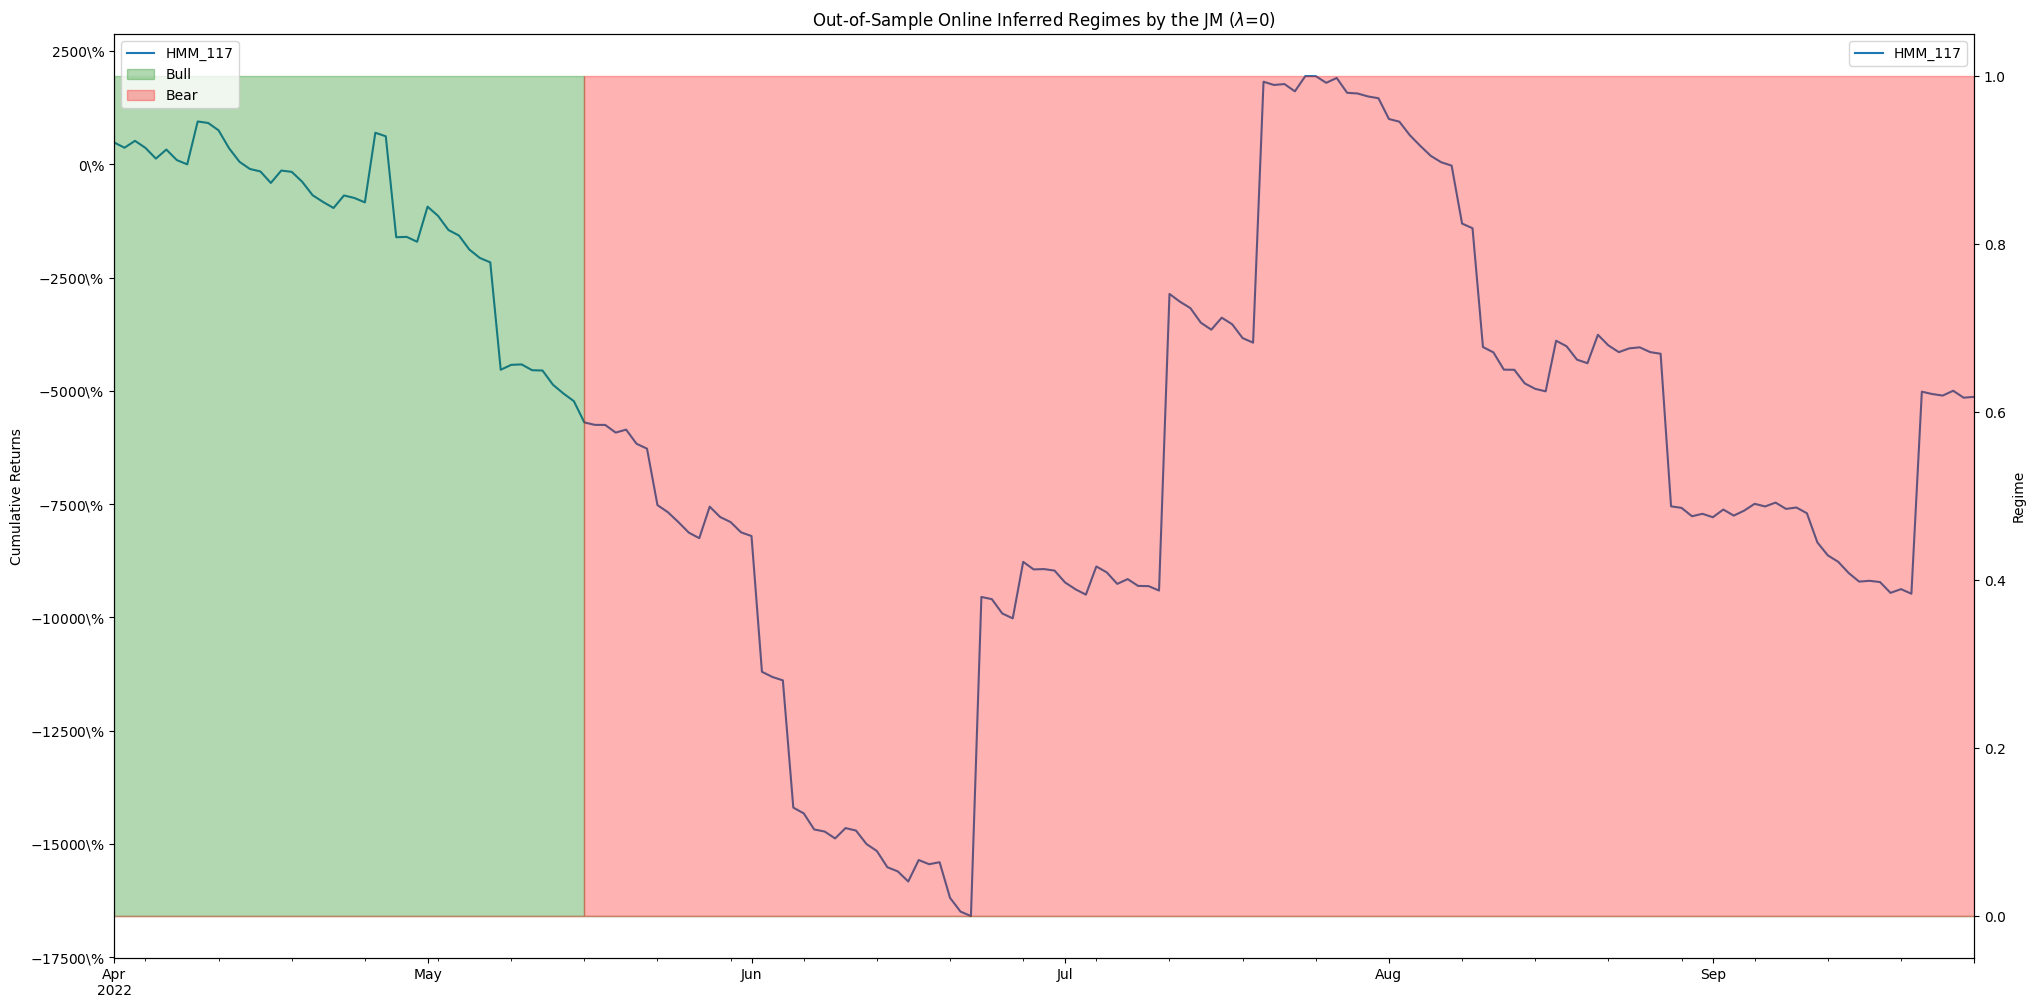

In [20]:
# plot and save
ax, ax2 = plot_regimes_and_cumret(labels_test_online, data.ret_ser, n_c=2, start_date=test_start, end_date=test_end, )
ax.set(title=f"Out-of-Sample Online Inferred Regimes by the JM ($\\lambda$={jump_penalty})")
savefig_plt(f"{get_curr_dir()}/plots/JM_lambd-{jump_penalty}_test_online.pdf")